<a href="https://colab.research.google.com/github/runnithan03/Dissertation/blob/main/Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pytorch + Plot

Epoch 1, Loss: 0.5691846613509063
Epoch 2, Loss: 0.4777439154629625
Epoch 3, Loss: 0.4511604699367973
Epoch 4, Loss: 0.43751878498227353
Epoch 5, Loss: 0.43484505747401453
Training complete.


epoch,train_loss,valid_loss,accuracy,time
0,0.443773,0.430028,0.760442,00:05
1,0.430061,0.430449,0.760442,00:04
2,0.439267,0.429950,0.760442,00:04
3,0.430191,0.427858,0.760442,00:04
4,0.431139,0.426776,0.760442,00:04


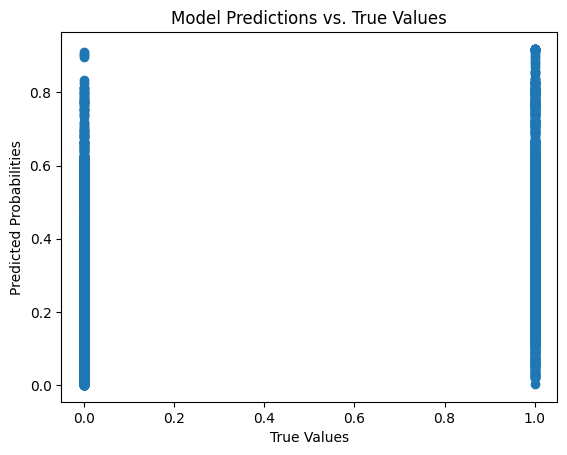

In [38]:
from fastai.callback.core import Callback

# Custom callback to convert target tensor to float
class ConvertTargetToFloat(Callback):
    def before_batch(self):
        self.learn.yb = (self.learn.yb[0].float(),)

# Sample dataset setup using `fastai`
path = untar_data(URLs.ADULT_SAMPLE)
dls = TabularDataLoaders.from_csv(
    path/'adult.csv',
    y_names="salary",
    cat_names=['workclass', 'education'],
    cont_names=['age', 'fnlwgt'],
    procs=[Categorify, FillMissing, Normalize],
    batch_size=64  # Adjust batch size as needed
)

# Extracting categorical sizes for the embedding layers
cat_sizes = [len(dls.train_ds.classes[c]) for c in dls.cat_names]
n_cont_features = len(dls.cont_names)

# Instantiate the model and move to device (CPU/GPU)
model = GLMWithEmbeddings(n_cont_features, cat_sizes).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization
loss_func = nn.BCEWithLogitsLoss()  # For binary classification

# Training using PyTorch with flexible unpacking of xb
epochs = 5  # Set a few epochs for quick demonstration

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in dls.train:
        # Unpack the relevant elements from the batch
        x_cat, x_cont, yb = batch[0].to(device), batch[1].to(device), batch[2].to(device)

        # Convert target to float and flatten
        yb = yb.float().view(-1)  # Flatten target to [batch_size]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(x_cat, x_cont)  # Keep the output shape as [batch_size, 1]
        outputs = outputs.view(-1)  # Flatten output to [batch_size] for compatibility with yb

        # Compute loss
        loss = loss_func(outputs, yb)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dls.train)}")

print("Training complete.")

# Fit the model using fastai's one-cycle policy with the custom callback
learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy, cbs=ConvertTargetToFloat())
learn.fit_one_cycle(5, 1e-2)

# Evaluate the model and plot predictions vs. true values
preds, targs = learn.get_preds()
preds = torch.sigmoid(preds)  # Apply sigmoid to get probabilities for binary classification

# Convert target values to float
targs = targs.float()

# Plotting the predictions vs. true values
plt.scatter(targs, preds)
plt.xlabel('True Values')
plt.ylabel('Predicted Probabilities')
plt.title('Model Predictions vs. True Values')
plt.show()